## Wykrywanie naczyń krwionośnych - Dno oka

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.util import img_as_float
from skimage.filters import frangi
from skimage.morphology import remove_small_objects, binary_closing, disk, skeletonize

In [10]:
def load_images(image_path, mask_path, expert_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    expert = cv2.imread(expert_path, cv2.IMREAD_GRAYSCALE)
    return image, (mask>0).astype(bool), (expert>0).astype(np.uint8)


def preprocess_image(image):
    green_channel = image[:, :, 1]
    kernel = np.ones((1, 1), np.uint8)
    dilated = cv2.dilate(green_channel, kernel, iterations=1)
    denoised = cv2.fastNlMeansDenoising(dilated, None, 2, 5, 21)
    equalized = cv2.equalizeHist(denoised)
    # blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
    # sharpened = cv2.addWeighted(equalized, 1.6, blurred, -0.4, 0)
    return green_channel, equalized, equalized


def apply_frangi_filter(image):
    image_float = img_as_float(image)
    vessels = frangi(image_float)
    v_min, v_max = np.percentile(vessels, [5, 95])
    vessels_clipped = np.clip(vessels, v_min, v_max)
    vessels_normalized = (vessels_clipped - v_min) / (v_max - v_min)
    return vessels_normalized


def threshold_vessels(vessels):
    threshold = filters.threshold_otsu(vessels)
    binary_mask = vessels > threshold
    return binary_mask



def postprocess_image(vessels: np.ndarray, mask: np.ndarray) -> np.ndarray:
    vessels = np.nan_to_num(vessels)
    binary = vessels > 0.35

    #Czyszczenie i zamykanie morfologiczne
    cleaned = remove_small_objects(binary, min_size=20)
    closed = binary_closing(cleaned, disk(6))
    skeleton = skeletonize(closed)

    mask = (mask > 0)
    skeleton = closed & mask

    return skeleton.astype(np.uint8)



def show_images(images, titles, figsize=(15, 5)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [374]:
image, vessel_mask, expert_mask = load_images(
        "healthy/01_h.jpg",
        "healthy_fovmask/01_h_mask.tif",
         "healthy_manualsegm/01_h.tif"
    )

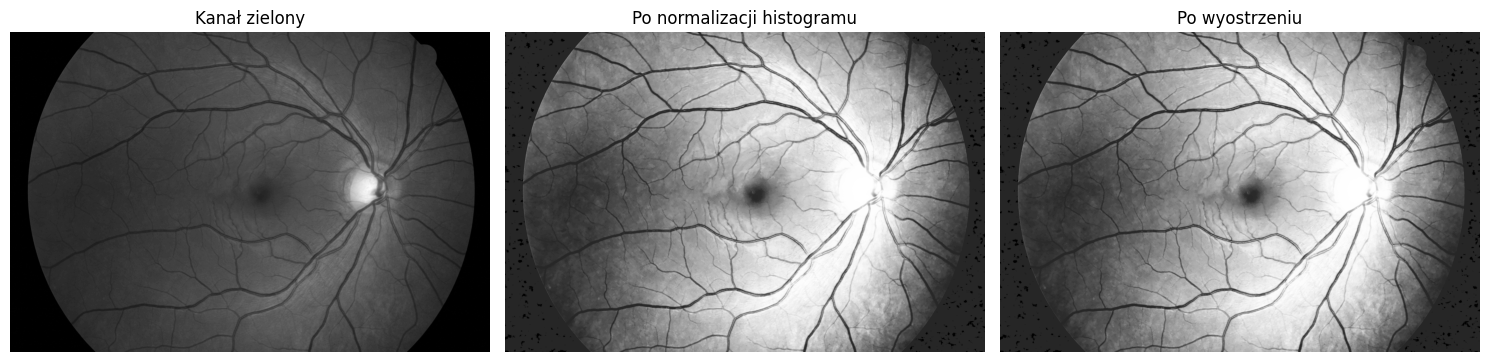

In [375]:
green_channel, equalized, sharpened = preprocess_image(image)

show_images([green_channel, equalized, sharpened], ["Kanał zielony", "Po normalizacji histogramu", "Po wyostrzeniu"])

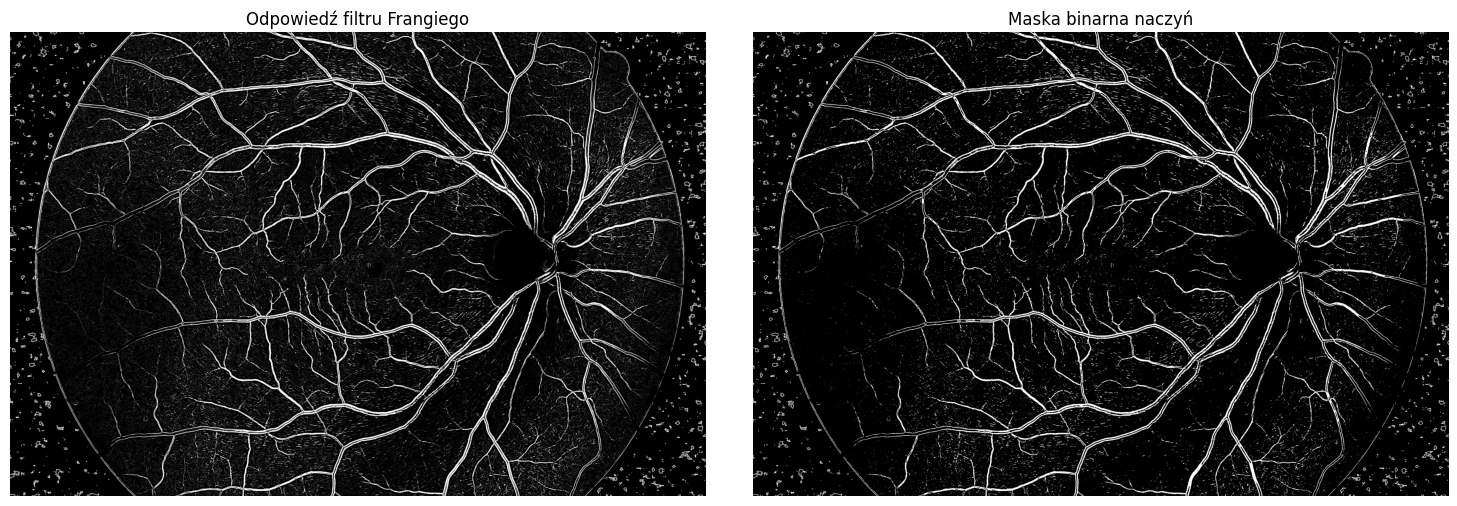

In [376]:
vessels = apply_frangi_filter(sharpened)
vessel_binary = threshold_vessels(vessels)

show_images([vessels, vessel_binary],["Odpowiedź filtru Frangiego", "Maska binarna naczyń"])

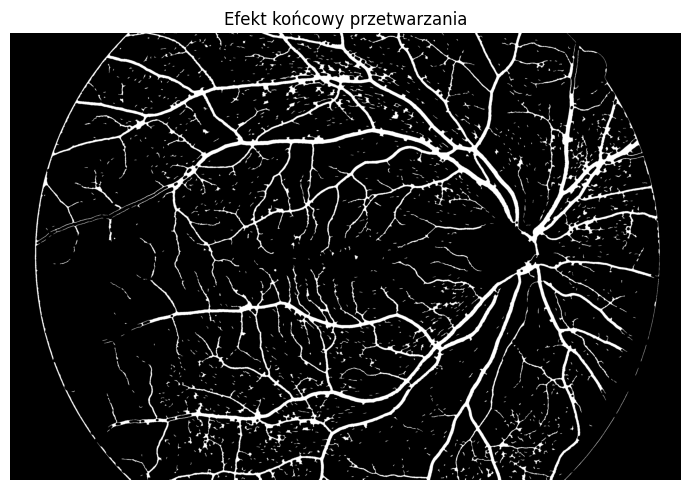

In [377]:
processed = postprocess_image(vessels, vessel_mask)

show_images([processed],['Efekt końcowy przetwarzania'])

 ## Ocena Efektywności

In [8]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

def compute_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    print(tn, fp, fn, tp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    harmonic_mean = 2 * (sensitivity * specificity) / (sensitivity + specificity + 1e-6)
    arithmetic_mean = (sensitivity + specificity) / 2
    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'harmonic_mean': harmonic_mean,
        'arithmetic_mean': arithmetic_mean
    }

def visualize_detection_comparison(expert_mask: np.ndarray, predicted_mask: np.ndarray, fov_mask: np.ndarray) -> np.ndarray:
    expert_mask = expert_mask.astype(bool)
    predicted_mask = predicted_mask.astype(bool)
    fov_mask = fov_mask.astype(bool)

    result_image = np.zeros((*expert_mask.shape, 3), dtype=np.uint8)

    tp = predicted_mask & expert_mask & fov_mask
    fn = ~predicted_mask & expert_mask & fov_mask
    fp = predicted_mask & ~expert_mask & fov_mask

    result_image[tp] = [255, 255, 255]  # White
    result_image[fn] = [0, 0, 255]      # Blue
    result_image[fp] = [255, 0, 0]      # Red
    return result_image


def display_segmentation_results(image: np.ndarray, predicted_mask: np.ndarray,
                                  expert_mask: np.ndarray, comparison_image: np.ndarray):
    show_images([image, predicted_mask, expert_mask, comparison_image], ["Obraz źródłowy", "Wykryte naczynia", "Maska ekspercka", "Porównanie wykrycia"])
    # print("FOV shape:", fov_mask.shape)
    # print("Expert mask nonzero:", np.count_nonzero(expert_mask))
    # print("Predicted mask nonzero:", np.count_nonzero(predicted_mask))
    # print("FOV nonzero:", np.count_nonzero(fov_mask))
    return """
    Legenda:
    - Białe: poprawne wykrycia (TP)
    - Niebieskie: brak wykrycia (FN)
    - Czerwone: fałszywe wykrycie (FP)
    - Czarne: tło lub prawidłowe odrzucenie (TN)
    """

    
def evaluate_retinal_segmentation(image_paths, mask_paths, fov_masks):
    results = []

    for img_path, msk_path, fov_path in zip(image_paths, mask_paths, fov_masks):
        # Wczytanie obrazów
        image, expert_mask, fov_mask = load_images(img_path, msk_path, fov_path)

        # Przetwarzanie
        _, _, sharpened = preprocess_image(image)
        vessels = apply_frangi_filter(sharpened)
        predicted_mask = postprocess_image(vessels, fov_mask)

        y_true = expert_mask[fov_mask == 1].flatten()
        y_pred = predicted_mask[fov_mask == 1].flatten()

        metrics = compute_metrics(y_true, y_pred)
        metrics["image"] = img_path.split('\\')[-1]
        results.append(metrics)

        comparison_image = visualize_detection_comparison(expert_mask, predicted_mask, fov_mask)
        legenda = display_segmentation_results(image, predicted_mask, expert_mask, comparison_image)
        
    print(legenda)
    return pd.DataFrame(results)

def load_test_data(n=5):
    base_dir = os.getcwd()
    image_dir = os.path.join(base_dir, "healthy")
    manual_dir = os.path.join(base_dir, "healthy_manualsegm")
    mask_dir = os.path.join(base_dir, "healthy_fovmask")
    
    image_files = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
    base_names = [os.path.splitext(os.path.basename(f))[0] for f in image_files[:n]]
    
    images  = [os.path.join(image_dir, f"{name}.jpg") for name in base_names]
    masks = [os.path.join(manual_dir, f"{name}.tif") for name in base_names]
    fovs  = [os.path.join(mask_dir,  f"{name}_mask.tif") for name in base_names]
    return images, masks, fovs

5866195 213700 260695 573193


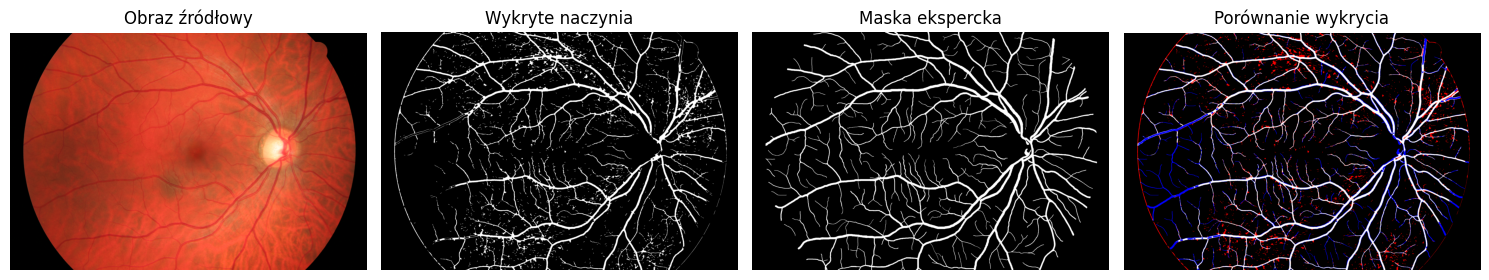

5890276 215671 240431 567991


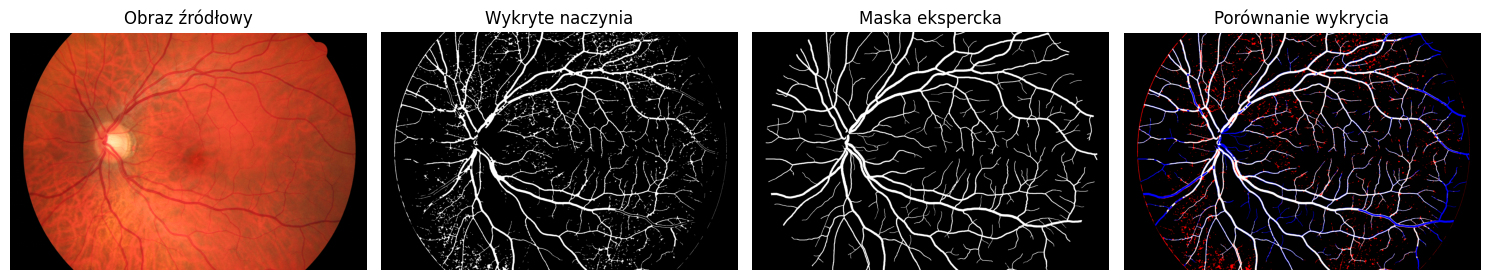

5555790 492156 276475 587651


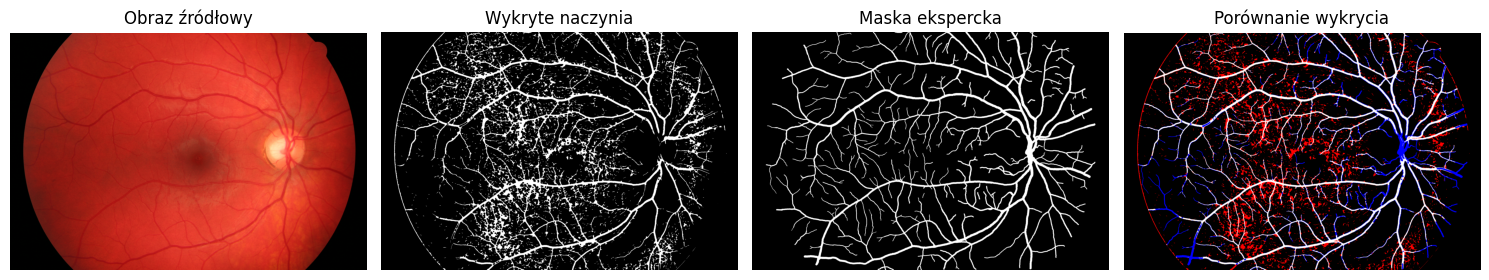

5897806 243611 225876 545719


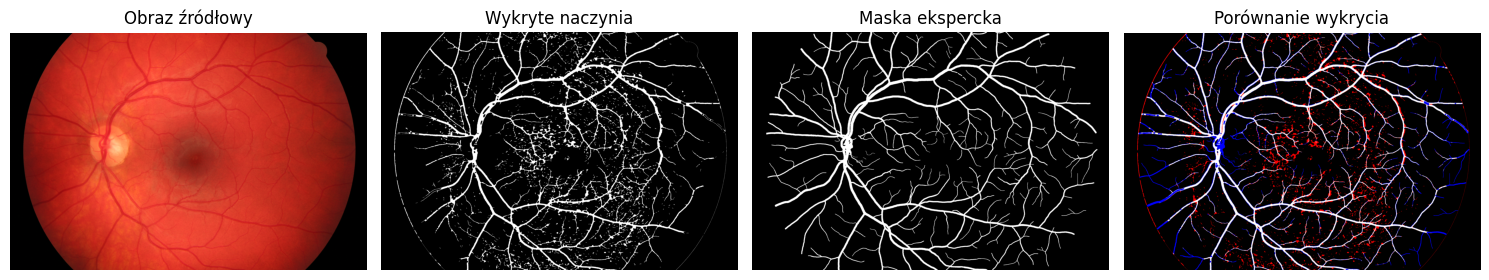

5877140 296185 233048 505733


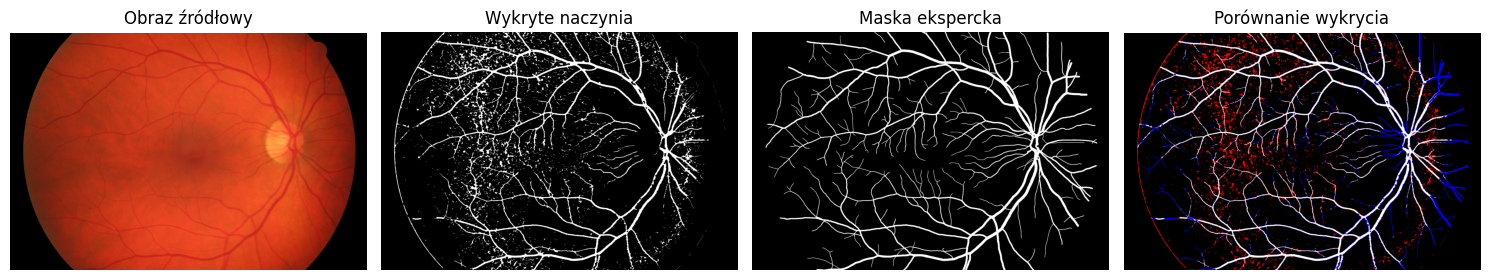


    Legenda:
    - Białe: poprawne wykrycia (TP)
    - Niebieskie: brak wykrycia (FN)
    - Czerwone: fałszywe wykrycie (FP)
    - Czarne: tło lub prawidłowe odrzucenie (TN)
    


accuracy  sensitivity  specificity  harmonic_mean  arithmetic_mean  \
0  0.931384     0.687374     0.964851       0.802812         0.826113   
1  0.934036     0.702592     0.964679       0.813036         0.833635   
2  0.888799     0.680052     0.918624       0.781537         0.799338   
3  0.932086     0.707261     0.960333       0.814594         0.833797   
4  0.923434     0.684551     0.952022       0.796429         0.818286   

      image  
0  01_h.jpg  
1  02_h.jpg  
2  03_h.jpg  
3  04_h.jpg  
4  05_h.jpg

In [407]:
images, masks, fovs = load_test_data()

evaluate_retinal_segmentation(images, masks, fovs)


### Random Forest

In [1]:
def get_segments(image, patch_size=15):
    segments = []
    h, w = image.shape[:2]
    h = h - h % patch_size
    w = w - w % patch_size
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            segment = image[y:y + patch_size, x:x + patch_size]
            segments.append(segment)
    return segments

def get_segment_stats(segment):
    gray_segment = cv2.cvtColor(segment, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray_segment)
    hu = cv2.HuMoments(moments).flatten()
    hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)

    r_var = np.var(segment[:, :, 2])
    g_var = np.var(segment[:, :, 1])
    b_var = np.var(segment[:, :, 0])

    return np.concatenate((hu, [r_var, g_var, b_var]))

def prepare_data(image_path, mask_path, patch_size=15):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    segments = get_segments(image, patch_size)
    mask_segments = get_segments(mask, patch_size)

    features = []
    labels = []

    for seg, msk in zip(segments, mask_segments):
        label = 1 if msk[patch_size//2, patch_size//2] > 0 else 0
        feat = get_segment_stats(seg)
        features.append(feat)
        labels.append(label)

    return np.array(features, dtype=np.float32), np.array(labels, dtype=np.uint8)



In [4]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import pandas as pd

X, y = prepare_data("healthy/01_h.jpg", "healthy_manualsegm/01_h.tif", patch_size=15)

rus = RandomUnderSampler(random_state=42)
X_bal, y_bal = rus.fit_resample(X, y)

clf = DecisionTreeClassifier(max_depth=30, min_samples_leaf=5, random_state=42)

clf.fit(X_bal, y_bal)



DecisionTreeClassifier(max_depth=30, min_samples_leaf=5, random_state=42)

In [5]:
def classify_segments_with_threshold(image_path, clf, threshold=0.01, patch_size=15):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    h = h - h % patch_size
    w = w - w % patch_size
    image = image[:h, :w]

    mask = np.zeros((h, w), dtype=np.uint8)
    vessel_count = 0

    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            patch = image[y:y + patch_size, x:x + patch_size]
            features = get_segment_stats(patch).reshape(1, -1)
            proba = clf.predict_proba(features)[0][1]
            if proba > threshold:
                mask[y:y + patch_size, x:x + patch_size] = 255
                vessel_count += 1

    print("Segmentny wykryte jako naczynia:", vessel_count)
    return mask


In [18]:
def evaluate_forest_segmentation(image_paths, mask_paths, fov_masks):
    results = []

    for img_path, msk_path, fov_path in zip(image_paths, mask_paths, fov_masks):
        # Wczytanie obrazów
        image, expert_mask, fov_mask = load_images(img_path, msk_path, fov_path)

        # Przetwarzanie
        predicted_mask = classify_segments_with_threshold(img_path, clf, patch_size=12, threshold=0.35)
        if predicted_mask.shape != expert_mask.shape:
            predicted_mask = cv2.resize(predicted_mask, (expert_mask.shape[1], expert_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_pred = predicted_mask.flatten() > 0
        y_true = expert_mask.flatten() > 0

        metrics = compute_metrics(y_true, y_pred) #y_true.astype(int), y_pred.astype(int)
        metrics["image"] = img_path.split('\\')[-1]
        results.append(metrics)

        comparison_image = visualize_detection_comparison(expert_mask, predicted_mask, fov_mask)
        legenda = display_segmentation_results(image, predicted_mask, expert_mask, comparison_image)
        
    print(legenda)
    return pd.DataFrame(results)

Segmentny wykryte jako naczynia: 13390
6042969 1308487 207123 626765


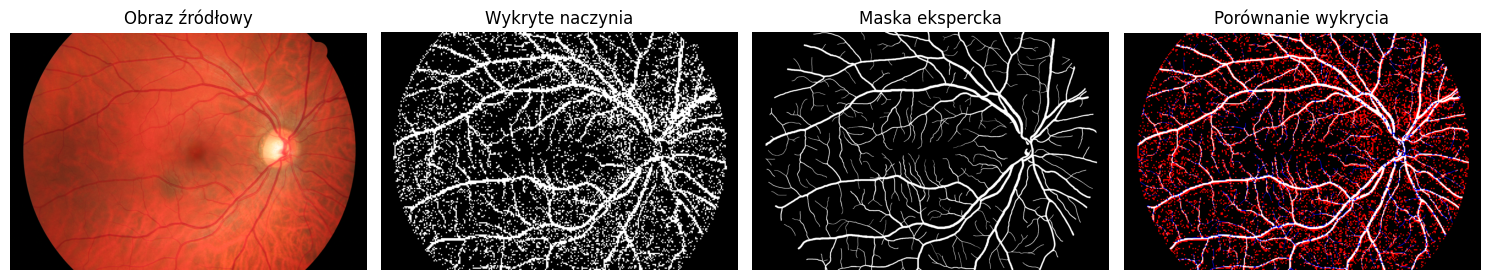

Segmentny wykryte jako naczynia: 13863
5995655 1381251 186277 622161


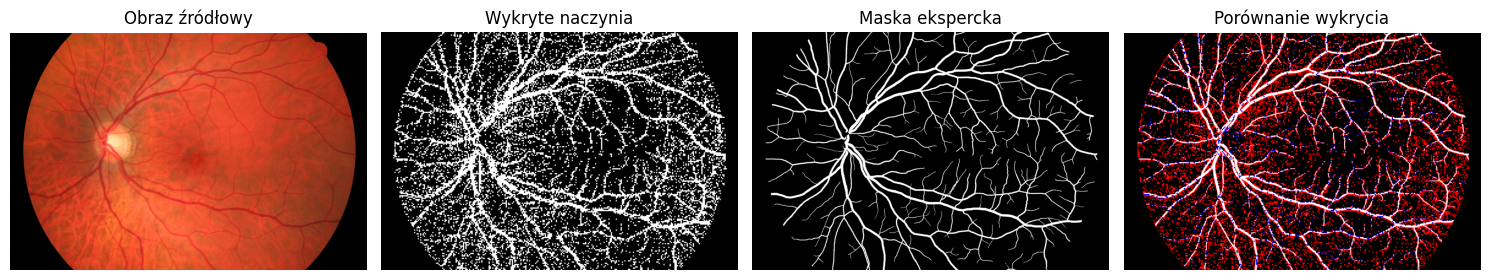

Segmentny wykryte jako naczynia: 15973
5670904 1650269 205952 658219


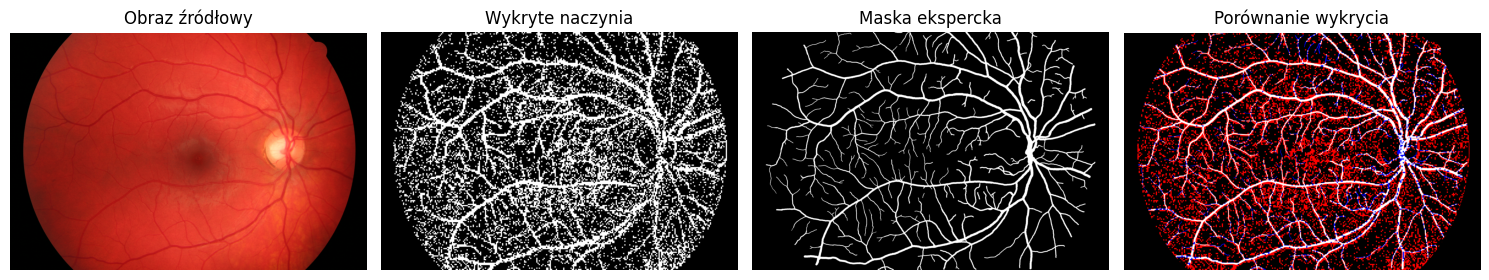

Segmentny wykryte jako naczynia: 15141
5805455 1608288 192397 579204


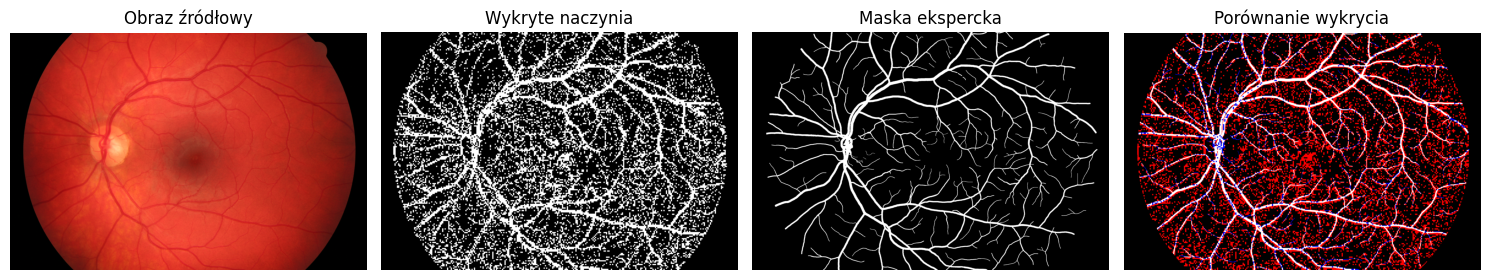

Segmentny wykryte jako naczynia: 8016
6708153 738405 319323 419463


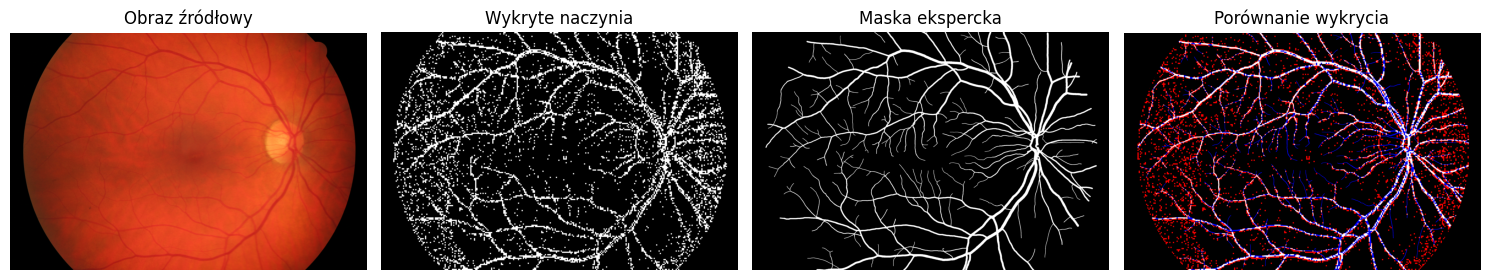


    Legenda:
    - Białe: poprawne wykrycia (TP)
    - Niebieskie: brak wykrycia (FN)
    - Czerwone: fałszywe wykrycie (FP)
    - Czarne: tło lub prawidłowe odrzucenie (TN)
    


accuracy  sensitivity  specificity  harmonic_mean  arithmetic_mean  \
0  0.814839     0.751618     0.822010       0.785239         0.786814   
1  0.808496     0.769584     0.812760       0.790583         0.791172   
2  0.773226     0.761677     0.774590       0.768078         0.768133   
3  0.780011     0.750652     0.783067       0.766516         0.766859   
4  0.870778     0.567773     0.900839       0.696538         0.734306   

      image  
0  01_h.jpg  
1  02_h.jpg  
2  03_h.jpg  
3  04_h.jpg  
4  05_h.jpg

In [19]:
images, masks, fovs = load_test_data()

evaluate_forest_segmentation(images, masks, fovs)

## Głęboka sieć neuronowa